In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import entropy
import traceback

# OPÇÕES DE AJUSTE:
num_bins = 100

# Preparação
def prepare_directories():
    output_dir = "modelos_testados_256qam_HISTOGRAM"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

# Carregar datasets
new_data = np.load('dataset/256qam/sent_data_tuple.npy')
received_data = np.load('dataset/256qam/received_data_tuple_sync-phase.npy')

new_data_complex = new_data[:, 0] + 1j * new_data[:, 1]
received_data_complex = received_data[:, 0] + 1j * received_data[:, 1]


# Função para calcular divergência KL (usando histogramas)
def calculate_kl_divergence_hist(signal1, signal2, num_bins=num_bins):
    signal1_real_imag = np.concatenate((signal1.real, signal1.imag))
    signal2_real_imag = np.concatenate((signal2.real, signal2.imag))

    hist_signal1, bin_edges = np.histogram(signal1_real_imag, bins=num_bins, density=True)
    hist_signal2, _ = np.histogram(signal2_real_imag, bins=bin_edges, density=True)

    epsilon = 1e-10
    hist_signal1 += epsilon
    hist_signal2 += epsilon

    hist_signal1 /= np.sum(hist_signal1)
    hist_signal2 /= np.sum(hist_signal2)

    kl_divergence = entropy(hist_signal1, hist_signal2)

    return kl_divergence

# Função para calcular EVM
def calculate_evm(reference_signal, test_signal):
    error_vector = test_signal - reference_signal
    magnitude_error = np.abs(error_vector)
    mean_power = np.mean(np.abs(reference_signal) ** 2)
    evm = np.sqrt(np.mean(magnitude_error ** 2) / mean_power)
    return evm * 100, 20 * np.log10(evm)

# Função para calcular potência de ruído
def calculate_noise_power(sent_signal, received_signal):
    noise = received_signal - sent_signal
    return np.mean(np.abs(noise) ** 2)

# Função para calcular RMS Error
def calculate_rms_error(sent_signal, received_signal):
    error_vector = received_signal - sent_signal
    return np.sqrt(np.mean(np.abs(error_vector) ** 2))

# Função para calcular métricas
def calculate_metrics(new_data_complex, received_data_complex, new_predictions_complex):
    metrics = {}
    metrics["KL (Sent vs. Received)"] = calculate_kl_divergence_hist(new_data_complex, received_data_complex)
    metrics["KL (Sent vs. Predicted)"] = calculate_kl_divergence_hist(new_data_complex, new_predictions_complex)
    metrics["KL (Received vs. Predicted)"] = calculate_kl_divergence_hist(received_data_complex, new_predictions_complex)

    metrics["EVM (%) Sent vs. Received"], metrics["EVM (dB) Sent vs. Received"] = calculate_evm(new_data_complex, received_data_complex)
    metrics["EVM (%) Sent vs. Predicted"], metrics["EVM (dB) Sent vs. Predicted"] = calculate_evm(new_data_complex, new_predictions_complex)
    metrics["EVM (%) Received vs. Predicted"], metrics["EVM (dB) Received vs. Predicted"] = calculate_evm(received_data_complex, new_predictions_complex)

    metrics["Noise Power (Sent vs. Received)"] = calculate_noise_power(new_data_complex, received_data_complex)
    metrics["Noise Power (Sent vs. Predicted)"] = calculate_noise_power(new_data_complex, new_predictions_complex)

    metrics["RMS Error (Sent vs. Received)"] = calculate_rms_error(new_data_complex, received_data_complex)
    metrics["RMS Error (Sent vs. Predicted)"] = calculate_rms_error(new_data_complex, new_predictions_complex)

    return metrics

# Função para salvar gráficos
def save_plots(sent_data, received_data, predicted_data, axis_limits, save_path):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    def plot_constellation(data, title, ax, axis_limits):
        ax.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Real Part', fontsize=14)
        ax.set_ylabel('Imaginary Part', fontsize=14)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlim(axis_limits)
        ax.set_ylim(axis_limits)

    sent_data_combined = np.column_stack((sent_data.real, sent_data.imag))
    received_data_combined = np.column_stack((received_data.real, received_data.imag))
    predicted_data_combined = np.column_stack((predicted_data.real, predicted_data.imag))

    plot_constellation(sent_data_combined, "Sent Signal Constellation", axs[0], axis_limits)
    plot_constellation(received_data_combined, "Measured Signal Constellation", axs[1], axis_limits)
    plot_constellation(predicted_data_combined, "Model Predicted Signal Constellation", axs[2], axis_limits)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Função para salvar overlay
def save_overlay(received_data, predicted_data, axis_limits, save_path):
    fig, ax = plt.subplots(figsize=(8, 8))

    received_data_combined = np.column_stack((received_data.real, received_data.imag))
    predicted_data_combined = np.column_stack((predicted_data.real, predicted_data.imag))

    ax.scatter(predicted_data_combined[:, 0], predicted_data_combined[:, 1], s=2, alpha=0.5, label='Predicted Signal', color='red')
    ax.scatter(received_data_combined[:, 0], received_data_combined[:, 1], s=2, alpha=0.5, label='Measured Signal')

    ax.set_title("Overlay: Measured vs Predicted Signal", fontsize=16)
    ax.set_xlabel('Real Part', fontsize=14)
    ax.set_ylabel('Imaginary Part', fontsize=14)
    ax.grid(True)
    ax.set_xlim(axis_limits)
    ax.set_ylim(axis_limits)
    ax.legend(fontsize=14, loc='center', markerscale=4)
    ax.tick_params(axis='both', which='major', labelsize=14)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


# Função para previsões em lotes
def predict_in_batches(model, data, batch_size=32000):
    predictions = []
    num_batches = len(data) // batch_size + (1 if len(data) % batch_size != 0 else 0)
    for i in range(num_batches):
        batch_data = data[i * batch_size: (i + 1) * batch_size]
        prediction_function = model.signatures["serving_default"]
        batch_predictions = prediction_function(tf.constant(batch_data))["output_0"]
        predictions.append(batch_predictions)
    return tf.concat(predictions, axis=0)


# Listar modelos
current_directory = os.getcwd()
model_directories = [f for f in os.listdir(current_directory) if os.path.isdir(os.path.join(current_directory, f))]

if not model_directories:
    print("No model directories found.")
    exit()

print(f"Found {len(model_directories)} models.")

# Processar modelos
output_dir = prepare_directories()

for model_dir in model_directories:
    model_path = os.path.join(current_directory, model_dir)
    if not os.path.exists(os.path.join(model_path, 'saved_model.pb')):
        print(f"Skipping directory {model_dir}: No valid SavedModel found.")
        continue

    try:
        # Carregar o modelo
        options = tf.saved_model.LoadOptions(experimental_io_device="/job:localhost")
        vae_loaded = tf.keras.models.load_model(model_path, options=options)

        # Previsões
        new_predictions = predict_in_batches(vae_loaded, new_data, batch_size=32000)
        new_predictions_np = new_predictions.numpy()
        new_predictions_complex = new_predictions_np[:, 0] + 1j * new_predictions_np[:, 1]

        # Calcular métricas
        metrics = calculate_metrics(new_data_complex, received_data_complex, new_predictions_complex)
        metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])

        # Salvar tabela
        metrics_save_path = os.path.join(output_dir, f"metrics_{model_dir}.csv")
        metrics_df.to_csv(metrics_save_path, index=False)

        # Salvar gráficos de constelação
        plots_save_path = os.path.join(output_dir, f"constellations_{model_dir}.png")
        save_plots(new_data_complex, received_data_complex, new_predictions_complex, [-0.7, 0.7], plots_save_path)

        # Salvar gráfico overlay
        overlay_save_path = os.path.join(output_dir, f"overlay_{model_dir}.png")
        save_overlay(received_data_complex, new_predictions_complex, [-0.7, 0.7], overlay_save_path)

        print(f"Model {model_dir} processed successfully.")

    except Exception as e:
        print(f"Error processing model {model_dir}: {e}")
        traceback.print_exc()

print("All models processed. Results saved in 'modelos_testados_256qam_HISTOGRAM' folder.")


Found 33 models.
Skipping directory tensorboard_old: No valid SavedModel found.


2025-01-27 04:04:19.808221: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 04:04:20.063336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46047 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-01-27 04:04:21.594123: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Model vae_model_savedmodel_paper2 processed successfully.
Skipping directory logs: No valid SavedModel found.
Model vae_model_savedmodel_disk_1MS processed successfully.
Model vae_model_savedmodel_phase processed successfully.
Model vae_model_savedmodel processed successfully.
Skipping directory .ipython: No valid SavedModel found.
Model vae_model_savedmodel_round processed successfully.
Skipping directory .ipynb_checkpoints: No valid SavedModel found.
Skipping directory modelos_testados_64qam_HISTOGRAM: No valid SavedModel found.
Model vae_model_kl2 processed successfully.
Model vae_model_savedmodel_5MS_100kS_Square processed successfully.
Model vae_model_savedmodel_paper processed successfully.
Model vae_model_savedmodel_test processed successfully.
Skipping directory simulations_4psk: No valid SavedModel found.
Skipping directory modelos_testados_16qam_HISTOGRAM: No valid SavedModel found.
Skipping directory modelos_testados_KDE: No valid SavedModel found.
Model vae_model_savedmodel

Testing num_bins=10
Testing num_bins=20
Testing num_bins=50
Testing num_bins=100
Testing num_bins=100
Best num_bins: 10 with normalized score: 0.12260123148598166


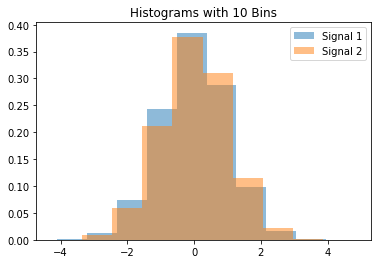

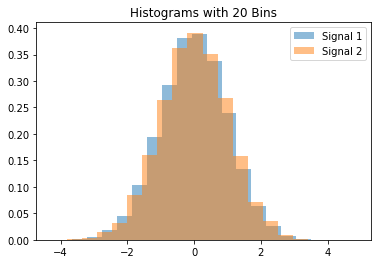

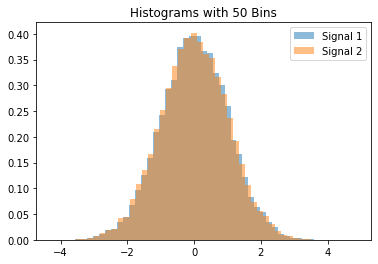

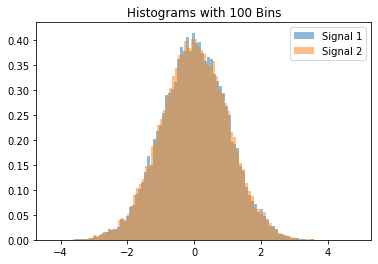

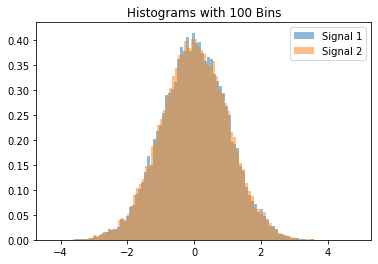

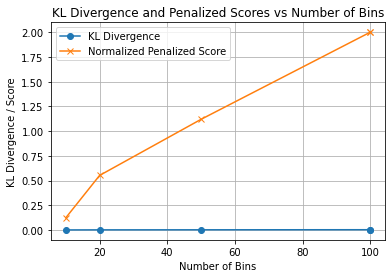

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Função para calcular divergência KL (usando histogramas)
def calculate_kl_divergence_hist(signal1, signal2, num_bins=100):
    signal1_real_imag = np.concatenate((signal1.real, signal1.imag))
    signal2_real_imag = np.concatenate((signal2.real, signal2.imag))

    hist_signal1, bin_edges = np.histogram(signal1_real_imag, bins=num_bins, density=True)
    hist_signal2, _ = np.histogram(signal2_real_imag, bins=bin_edges, density=True)

    epsilon = 1e-10
    hist_signal1 += epsilon
    hist_signal2 += epsilon

    hist_signal1 /= np.sum(hist_signal1)
    hist_signal2 /= np.sum(hist_signal2)

    kl_divergence = entropy(hist_signal1, hist_signal2)

    return kl_divergence

# Função para testar diferentes bins com penalização e normalização
def find_best_num_bins(new_data_complex, received_data_complex):
    best_score = float('inf')
    best_bins = None
    results = []

    # Intervalo dinâmico de bins baseado no tamanho do dataset
    max_bins = int(len(new_data_complex) ** 0.5)
    bins_to_test = [10, 20, 50, 100, max_bins]

    kl_values = []
    penalties = []

    for num_bins in bins_to_test:
        print(f"Testing num_bins={num_bins}")
        kl_divergence = calculate_kl_divergence_hist(new_data_complex, received_data_complex, num_bins=num_bins)
        penalty = num_bins * 0.01  # Penalizar bins menores

        kl_values.append(kl_divergence)
        penalties.append(penalty)

    # Normalizar KL e penalização
    kl_values_normalized = [kl / max(kl_values) for kl in kl_values]
    penalties_normalized = [pen / max(penalties) for pen in penalties]

    for idx, num_bins in enumerate(bins_to_test):
        score = kl_values_normalized[idx] + penalties_normalized[idx]
        results.append((num_bins, kl_values[idx], score))

        if score < best_score:
            best_score = score
            best_bins = num_bins

    print(f"Best num_bins: {best_bins} with normalized score: {best_score}")

    # Visualização dos histogramas para diferentes números de bins
    signal1_real_imag = np.concatenate((new_data_complex.real, new_data_complex.imag))
    signal2_real_imag = np.concatenate((received_data_complex.real, received_data_complex.imag))

    for num_bins in bins_to_test:
        plt.figure()
        plt.hist(signal1_real_imag, bins=num_bins, alpha=0.5, label="Signal 1", density=True)
        plt.hist(signal2_real_imag, bins=num_bins, alpha=0.5, label="Signal 2", density=True)
        plt.legend()
        plt.title(f"Histograms with {num_bins} Bins")
        plt.show()

    return results

# Exemplo de uso
if __name__ == "__main__":
    # Substitua isso pelos seus dados reais
    new_data = np.random.randn(10000) + 1j * np.random.randn(10000)
    received_data = new_data + (np.random.randn(10000) + 1j * np.random.randn(10000)) * 0.1

    # Calcular os bins ideais
    bin_results = find_best_num_bins(new_data, received_data)

    # Plotar resultados
    bins, kl_values, scores = zip(*bin_results)
    plt.plot(bins, kl_values, marker='o', label='KL Divergence')
    plt.plot(bins, scores, marker='x', label='Normalized Penalized Score')
    plt.xlabel("Number of Bins")
    plt.ylabel("KL Divergence / Score")
    plt.title("KL Divergence and Penalized Scores vs Number of Bins")
    plt.legend()
    plt.grid()
    plt.show()


In [3]:
from scipy.stats import shapiro, kstest, norm

signal_real_imag = np.concatenate((new_data.real, new_data.imag))
stat, p_value = shapiro(signal_real_imag)
print(f"Shapiro-Wilk test: Statistic={stat}, p-value={p_value}")

# Kolmogorov-Smirnov test
stat, p_value = kstest(signal_real_imag, 'norm', args=(np.mean(signal_real_imag), np.std(signal_real_imag)))
print(f"Kolmogorov-Smirnov test: Statistic={stat}, p-value={p_value}")


Shapiro-Wilk test: Statistic=0.9998385906219482, p-value=0.15863855183124542
Kolmogorov-Smirnov test: Statistic=0.004487155577643898, p-value=0.8154633861771952


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


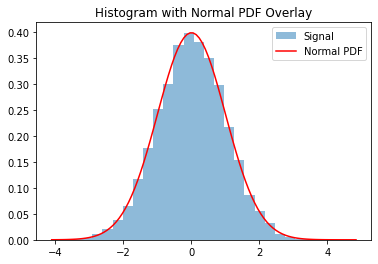

In [4]:
from scipy.stats import norm

mean, std = np.mean(signal_real_imag), np.std(signal_real_imag)
x = np.linspace(min(signal_real_imag), max(signal_real_imag), 100)
pdf = norm.pdf(x, mean, std)

plt.hist(signal_real_imag, bins=30, alpha=0.5, label="Signal", density=True)
plt.plot(x, pdf, label="Normal PDF", color='red')
plt.legend()
plt.title("Histogram with Normal PDF Overlay")
plt.show()


In [5]:

# Pasta com os arquivos CSV
metrics_folder = output_dir

# Listar arquivos CSV
csv_files = [f for f in os.listdir(metrics_folder) if f.endswith(".csv")]

# Função para calcular o máximo de cada diferença nos arquivos CSV
def calculate_max_differences(metrics_folder, csv_files):
    max_differences = {
        "KL Difference": 0,
        "EVM Difference": 0,
        "Noise Power Difference": 0,
        "RMS Error Difference": 0,
    }

    for csv_file in csv_files:
        file_path = os.path.join(metrics_folder, csv_file)
        metrics_df = pd.read_csv(file_path, skipinitialspace=True)
        metrics = metrics_df.set_index("Metric")["Value"].to_dict()

        # Calcular diferenças para normalização
        kl_diff = abs(metrics["KL (Sent vs. Received)"] - metrics["KL (Sent vs. Predicted)"])
        evm_diff = abs(metrics["EVM (%) Sent vs. Received"] - metrics["EVM (%) Sent vs. Predicted"])
        noise_diff = abs(metrics["Noise Power (Sent vs. Received)"] - metrics["Noise Power (Sent vs. Predicted)"])
        rms_diff = abs(metrics["RMS Error (Sent vs. Received)"] - metrics["RMS Error (Sent vs. Predicted)"])

        # Atualizar os máximos
        max_differences["KL Difference"] = max(max_differences["KL Difference"], kl_diff)
        max_differences["EVM Difference"] = max(max_differences["EVM Difference"], evm_diff)
        max_differences["Noise Power Difference"] = max(max_differences["Noise Power Difference"], noise_diff)
        max_differences["RMS Error Difference"] = max(max_differences["RMS Error Difference"], rms_diff)

    return max_differences

# Função para calcular a pontuação de um modelo
def calculate_model_score(metrics, max_differences):
    # Calcular diferenças normalizadas
    kl_diff = abs(metrics["KL (Sent vs. Received)"] - metrics["KL (Sent vs. Predicted)"]) / max_differences["KL Difference"]
    evm_diff = abs(metrics["EVM (%) Sent vs. Received"] - metrics["EVM (%) Sent vs. Predicted"]) / max_differences["EVM Difference"]
    noise_diff = abs(metrics["Noise Power (Sent vs. Received)"] - metrics["Noise Power (Sent vs. Predicted)"]) / max_differences["Noise Power Difference"]
    rms_diff = abs(metrics["RMS Error (Sent vs. Received)"] - metrics["RMS Error (Sent vs. Predicted)"]) / max_differences["RMS Error Difference"]

    # Calcular o score com pesos ajustados
    score = 0
    score += kl_diff * 0.5  # KL Divergence tem prioridade alta
    score += evm_diff * 0.6  # EVM é ainda mais importante
    score += noise_diff * 0.2  # Noise Power tem prioridade moderada
    score += rms_diff * 0.2  # RMS Error tem prioridade moderada

    return score

# Processar os arquivos e calcular pontuações
max_differences = calculate_max_differences(metrics_folder, csv_files)
model_scores = []

for csv_file in csv_files:
    file_path = os.path.join(metrics_folder, csv_file)
    try:
        # Ler o arquivo CSV
        metrics_df = pd.read_csv(file_path, skipinitialspace=True)

        # Verificar se as colunas esperadas estão presentes
        if "Metric" in metrics_df.columns and "Value" in metrics_df.columns:
            metrics = metrics_df.set_index("Metric")["Value"].to_dict()
            score = calculate_model_score(metrics, max_differences)
            model_scores.append((csv_file, score))
        else:
            print(f"Skipping file {csv_file}: Missing required columns.")
    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")

# Ordenar modelos pelo score (menor é melhor)
model_scores.sort(key=lambda x: x[1])

# Mostrar os resultados
print("Model Rankings:")
for rank, (model_name, score) in enumerate(model_scores, start=1):
    print(f"{rank}. {model_name} - Score: {score:.6f}")

# Melhor modelo
if model_scores:
    best_model = model_scores[0]
    print(f"\nBest Model: {best_model[0]} with Score: {best_model[1]:.6f}")
else:
    print("No valid models found.")


Model Rankings:
1. metrics_vae_model_kl2.csv - Score: 0.002526
2. metrics_vae_model_savedmodel_paper.csv - Score: 0.004388
3. metrics_vae_model_kl3.csv - Score: 0.007389
4. metrics_vae_model_savedmodel_paper2.csv - Score: 0.009515
5. metrics_vae_model_savedmodel_phase.csv - Score: 0.009803
6. metrics_vae_model_savedmodel_led_model3.csv - Score: 0.012668
7. metrics_vae_model_savedmodel_5MS_100kS_Square.csv - Score: 0.017412
8. metrics_vae_model_savedmodel_Square_less_evm.csv - Score: 0.017820
9. metrics_vae_model_savedmodel_led_model.csv - Score: 0.018894
10. metrics_vae_model_savedmodel_novo-disk.csv - Score: 0.021085
11. metrics_vae_model_savedmodel.csv - Score: 0.022451
12. metrics_vae_model_savedmodel_led_model2.csv - Score: 0.025071
13. metrics_vae_model_savedmodel_test.csv - Score: 0.025133
14. metrics_vae_model_savedmodel_disk_10MS.csv - Score: 0.025544
15. metrics_vae_model_savedmodel_disk_1MS.csv - Score: 0.025654
16. metrics_vae_model_savedmodel_round.csv - Score: 0.025675
17.